# Car removal by 2D CWT

Importing necessary libraries

In [1]:
cd ..

/net/server2/homes/sep/fantine/projects/earthquake-detection-ml


In [2]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np

from cwt import helper
from cwt import cwt
from plot_utils import plot_utils as plot

In [3]:
def read_hdf5(filename):
  with h5py.File(filename, 'r') as f:
    return f.get('input')[()]

## Visualize the data

In [38]:
datapath = '/scr1/fantine/earthquake-detection-ml/'
filename = os.path.join(datapath, 'processed_data/das/event/01000/event_01459_1.h5')
data = read_hdf5(filename)

In [36]:
flipped = data[::-1]

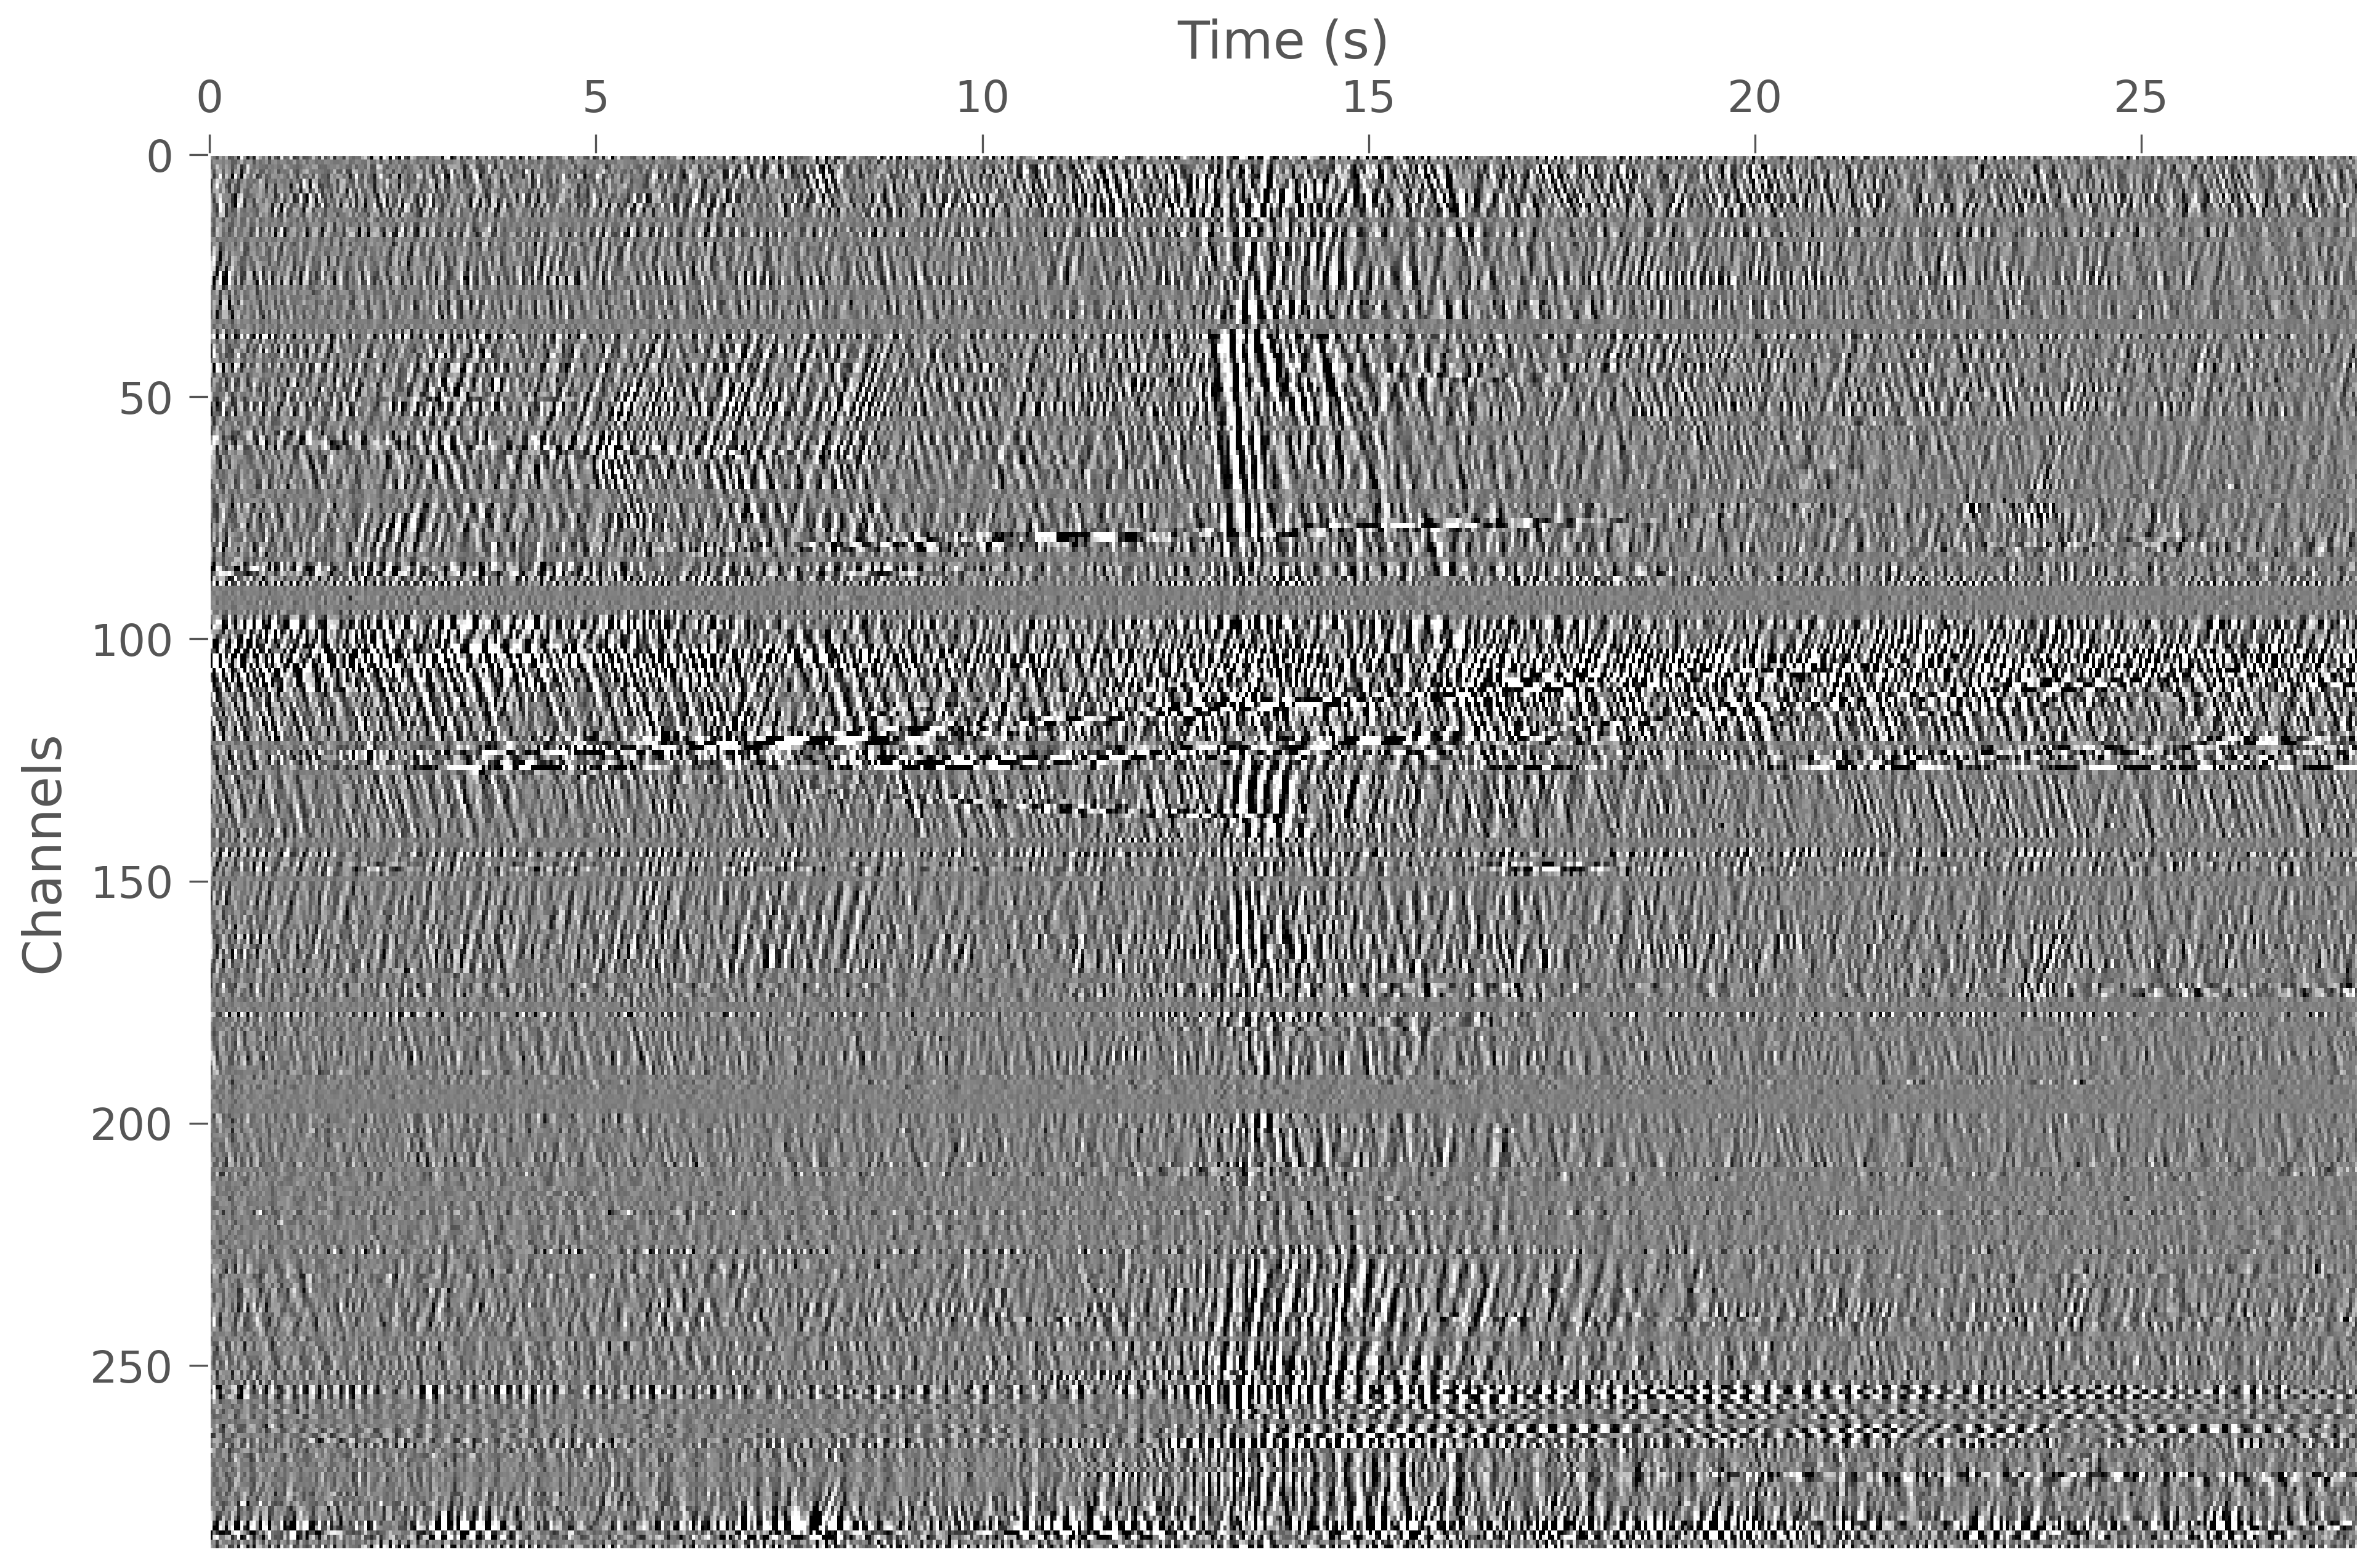

In [41]:
with plt.style.context('plot_utils/custom.mplstyle'):
    plot.seismic(flipped.T, labelx='Time (s)', labelt='Channels', dx=0.04, dt=1, filename='event_01459_2.pdf')

## Compute 2D CWT

In [20]:
x = data.T
dx = 1
dt = 0.04
# Find the next power of two
npad = helper.next_p2(x.shape[0] + 1)
# Padding parameters
tdiff = (npad - x.shape[0]) // 2
bdiff = npad - x.shape[0] - tdiff
# Find the next power of two
npad = helper.next_p2(x.shape[1] + 1)
# Padding parameters
ldiff = (npad - x.shape[1]) // 2
rdiff = npad - x.shape[1] - ldiff
# Pad data
x_pad = np.pad(x, ((tdiff, bdiff), (ldiff, rdiff)), 'constant')
dj = 1  # voices per octave
# Wavelet scaling factors
scales = cwt.dyadic_scales(x.shape[0], dj)
# This function computes the dyadic scales over the full space
# but we actually do not need the largest scales
scales = scales
# Wavelet rotation angles
nthetas = 6
thetas = np.pi * np.linspace(0, 1, nthetas + 1)
thetas = thetas[1:]
X = cwt.cwt2d(x_pad, scales, thetas, dt, dx)
X = X[:, :, tdiff:-bdiff, ldiff:-rdiff]
# return np.abs(np.squeeze(X).T)

In [21]:
X.shape

(9, 6, 695, 288)

In [22]:
labels = np.zeros_like(X[:,:,0,0])
labels[0] = 1
labels[0, 2] = 0
labels[1] = 1
labels[1, 2] = 0
labels[2] = 1
labels[2, 2] = 0
labels[3] = 1
labels[3:2] = 0

In [23]:
mask = np.zeros_like(X)
clip=98
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i, j] == 1:
            threshold = np.percentile(X[i, j], clip)
            mask[i, j] = np.where(np.abs(X[i, j]) > threshold, 1, 0)

In [24]:
mute = mask == 1
Y = np.copy(X)
Y[mute] = 0 
ix_mute = cwt.icwt2d(Y, scales, thetas, dt, dx)

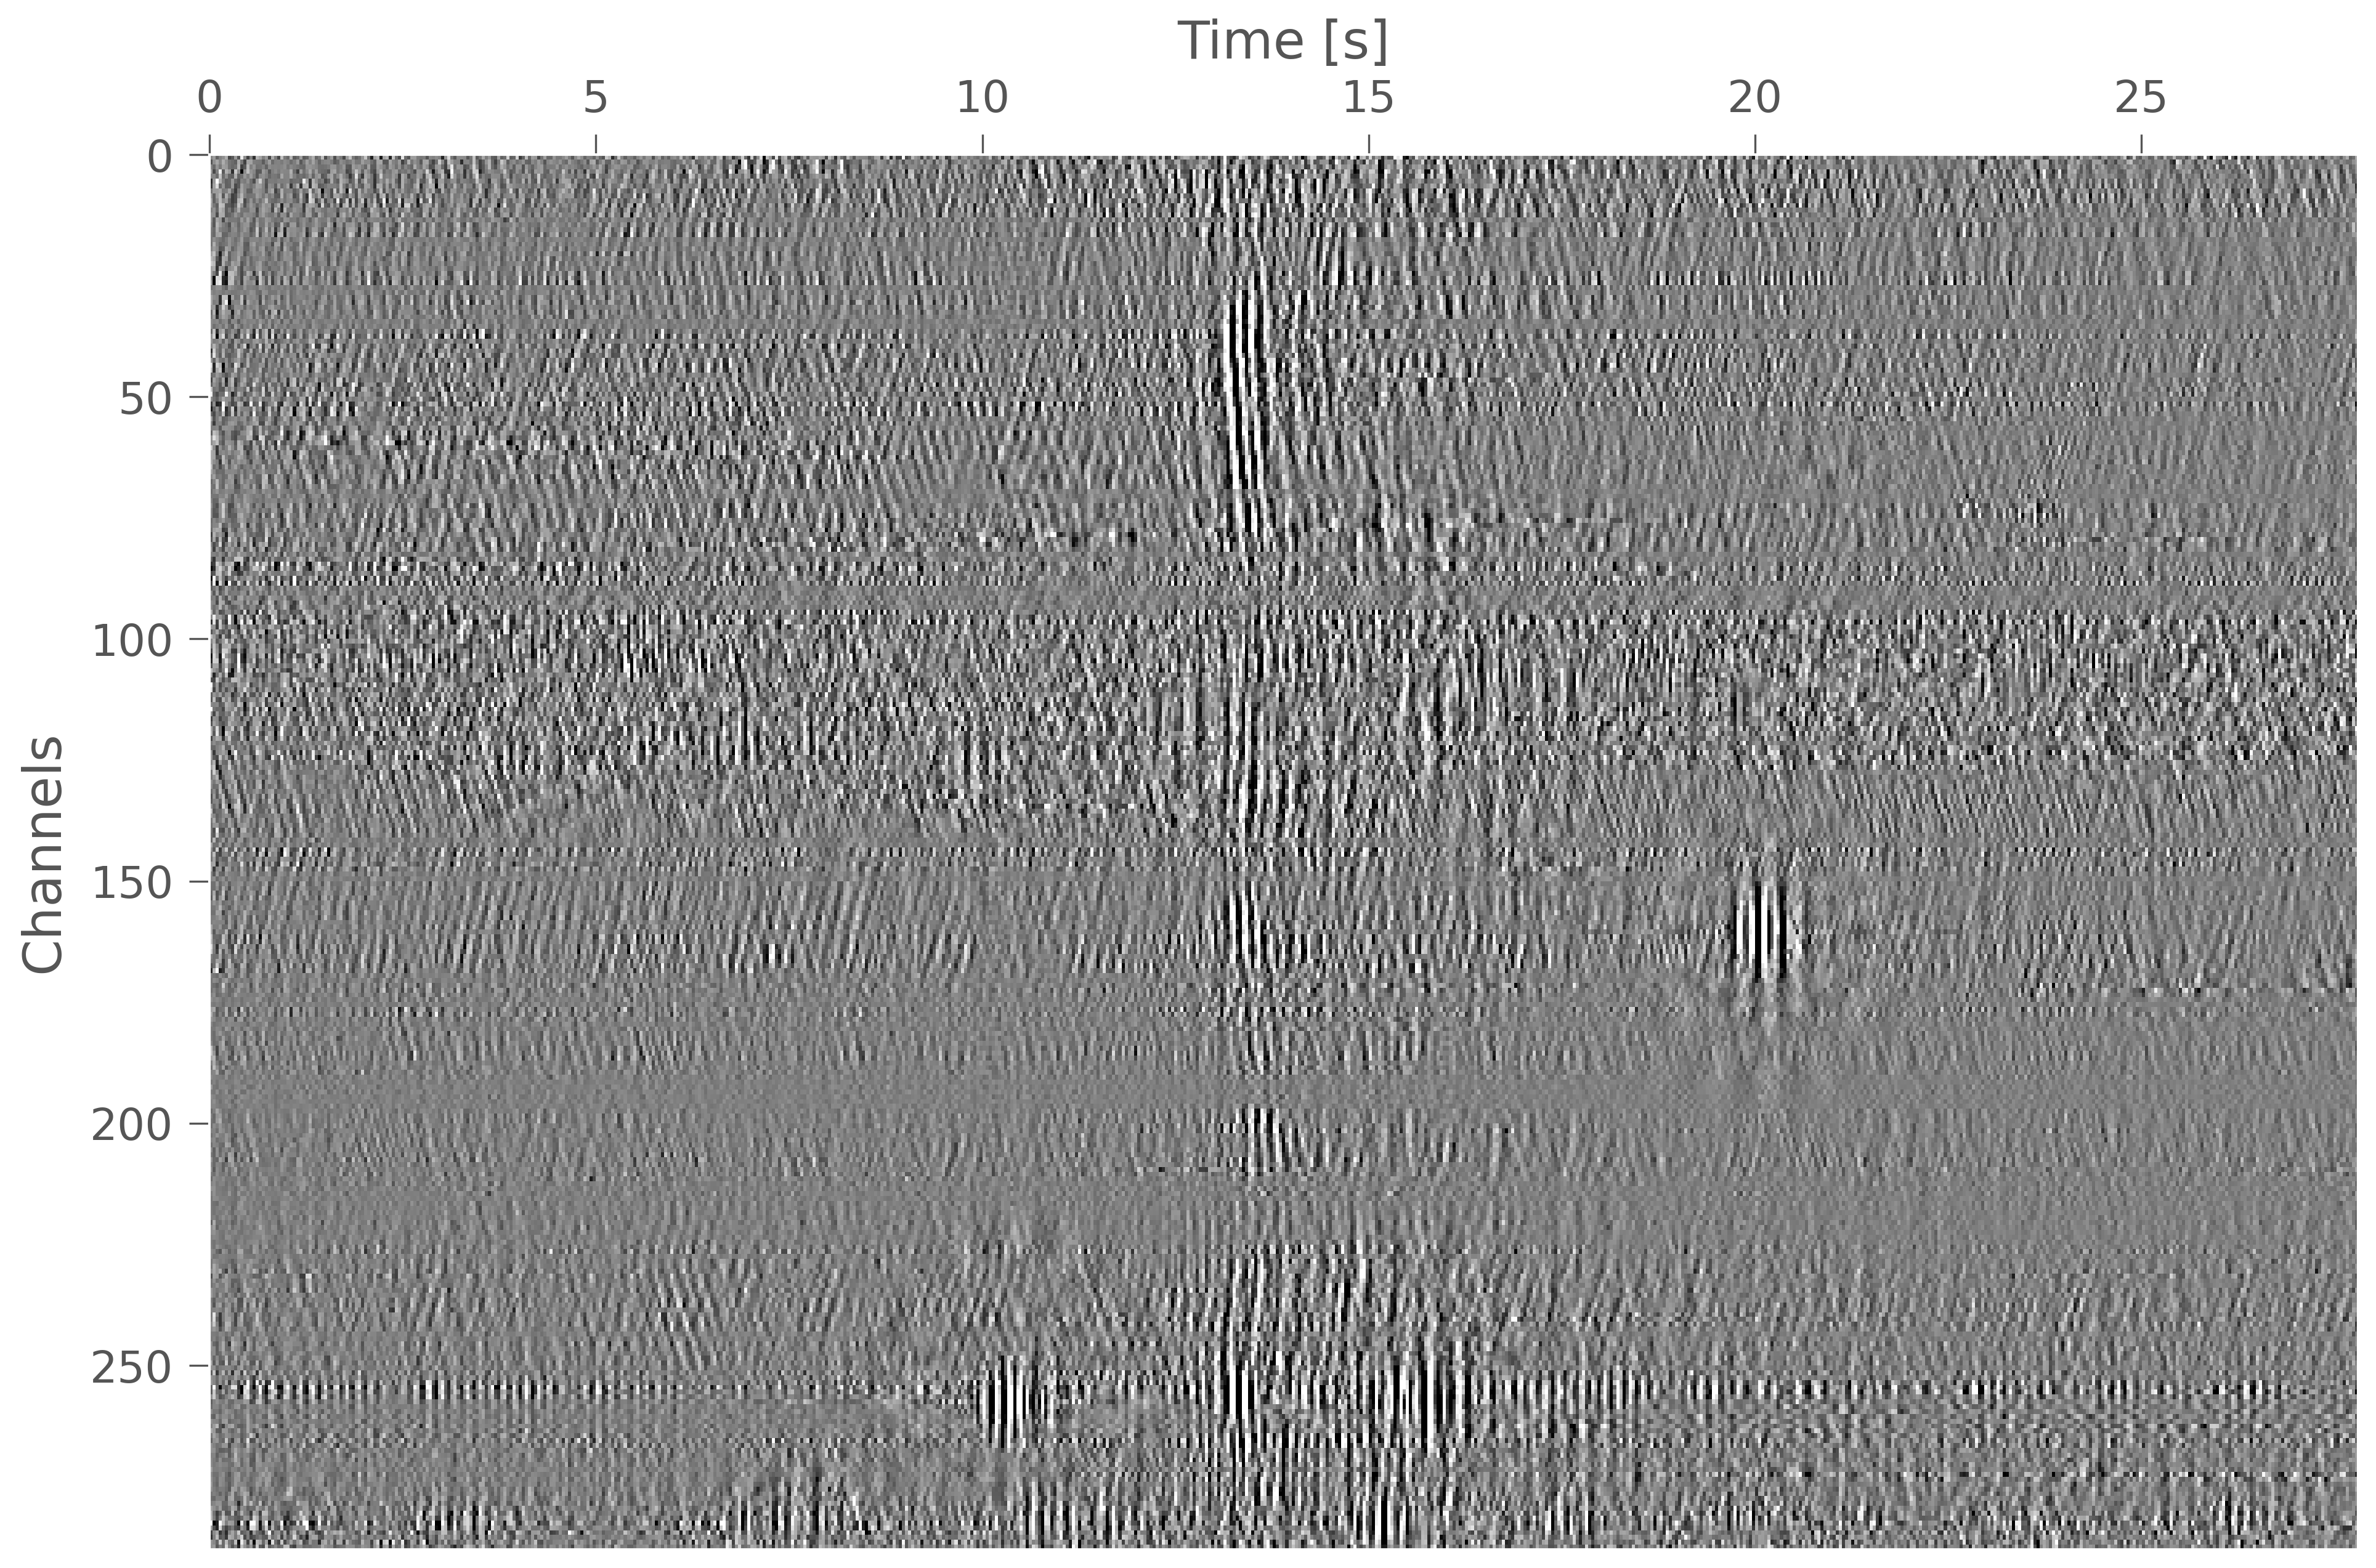

In [25]:
with plt.style.context('plot_utils/custom.mplstyle'):
    plot.seismic(ix_mute, dx=1/25, dt=1, clip=99, labelx='Time [s]', labelt='Channels', filename='event_01459_filtered.pdf')

In [127]:
import matplotlib.ticker as ticker

def cwt2d(X, dt, dx, scales, thetas, component='abs', clip=0.1, filename=''):
    """Plots 2D CWT coefficients in an interpretable way. 
    If filename is not empty, saves the plot to file. 
    
    Args: 
        X (4d ndarray): 2D CWT coefficients
        dt (float): sampling rate in time
        dx (float): sampling rate in space
        component (str): 'abs', 'real', 'imag', 'phase'
        clip (float): Strength of color bar clip
        filename (str): name of the file to save the plot"""
    
    # TODO Add options for different numbers of scales
    # TODO Add options for different angles
    # TODO Change to frequency and wavenumber bands
    
#     plt.rcParams['figure.figsize'] = (19, 17)
    plt.subplots_adjust(wspace=0.09, hspace=0.13)
    f = cwt.freq_from_scales(scales, dt)
    k = cwt.freq_from_scales(scales, dx)
    
    print(f)
    print(k)

    if component =='abs':
        tmp = np.abs(X)
    elif component == 'real':
        tmp = np.real(X)
    elif component == 'imag':
        tmp = np.imag(X)
    elif component == 'phase':
        tmp = np.angle(X)
    else: 
        print('Invalid data component')
        return ' '

#     vmax = clip * np.amax(tmp)
#     vmin = 0
        
    ymax = tmp.shape[3] * dx
    xmax = tmp.shape[2] * dt

#     nrows = (scales.shape[0])
    nrows = (scales.shape[0]) 
    ncols = thetas.shape[0] 
    
    for j in range(ncols):
        for i in range(nrows):
            ax = plt.subplot(ncols + 1, nrows, j * nrows + i + 1)
#             if j == 0: 
#                 ax.axis('off')
#                 if i > 0: 
# #                     ax.set_xlim(0, 1)
# #                     ax.set_ylim(0, 1)
# #                     text = '{:2.0f}\n\n{:04.4f}'.format(f[3 + (i - 1)*2], k[3 + (i - 1)*2])
#                     text = 'test1'
#                     ax.text(0.5, 0.9, text, horizontalalignment='center', verticalalignment='center')
#                     plt.arrow(0.5, 0.85, 0, 0.1, width=1, head_width=0, head_length=0, fc='Black')
#                 else:
#                     text = 'Scales       pseudo-frequency (Hz)\n\n                pseudo-wavenumber (1/m)'
#                     ax.text(0.5, 0.9, text, horizontalalignment='center', verticalalignment='center')
#                     plt.arrow(0.1, 0.9, 7.3, 0, width=0.005, head_width=0.1, head_length=0.07, clip_on=False, fc='Black')
#             if i == 0:
#                 ax.axis('off')
#                 if j > 0:
# #                     text = angle_labels[j - 1]
#                     text = 'test2'
#                     ax.text(0, 0.5, text, horizontalalignment='center', verticalalignment='center', rotation='vertical')
#                     plt.arrow(0.065, 0.5, 0.03, 0, width=0.0001, head_width=0, head_length=0, fc='Black')
#                     plt.arrow(0.5, 0.25, 0.2 * np.cos(thetas[j-1]), 0.2 * np.sin(thetas[j-1]), width=0.005, head_width=0.05, head_length=0.05, clip_on=False, fc='#9b9b9b', ec='#9b9b9b')
#                 else:
#                     text = 'Angles'
#                     ax.text(0, 0.3, text, horizontalalignment='center', verticalalignment='center', rotation='vertical')
#                     plt.arrow(0.1, 0.9, 0, -9.55, width=0.005, head_width=0.07, head_length=0.1, clip_on=False, fc='Black')
    #             print(i,j)
            vmax = np.percentile(tmp[i, j], clip)
            vmin = np.percentile(tmp[i, j], 100 - clip)
            ax.imshow(tmp[i, j].T, aspect='auto', extent=[0, xmax, ymax, 0], vmin=vmin, vmax=vmax, cmap='viridis')
#             ax.imshow(tmp[(i)*2, j], aspect='auto', vmin=vmin, vmax=vmax, extent=[0, xmax, tmax, 0], cmap='viridis')
            ax.set_ylabel('Channels')
            ax.set_xlabel('Time (s)')
            ax.tick_params(labelbottom=False, labeltop=True, bottom=False, top=True)
            ax.xaxis.set_label_position('top')
#             ticks = ticker.FormatStrFormatter('%d')
#             ax.yaxis.set_major_formatter(ticks)
            if j == 0:
                if i == 0:
                    plt.title('12 Hz', fontdict={'fontsize': 17}, pad=15)
                if i == 1:
                    plt.title('6 Hz', fontdict={'fontsize': 17}, pad=15)
                if i == 2:
                    plt.title('3 Hz', fontdict={'fontsize': 17}, pad=15)
            if i > 0: 
                ax.tick_params(left=False, labelleft=False)
                ax.set_ylabel(' ')
            if j > 0: 
                ax.tick_params(top=False, labeltop=False)
                ax.set_xlabel(' ')

    if filename:
        plt.savefig(filename)

[12.5    6.25   3.125]
[0.5   0.25  0.125]


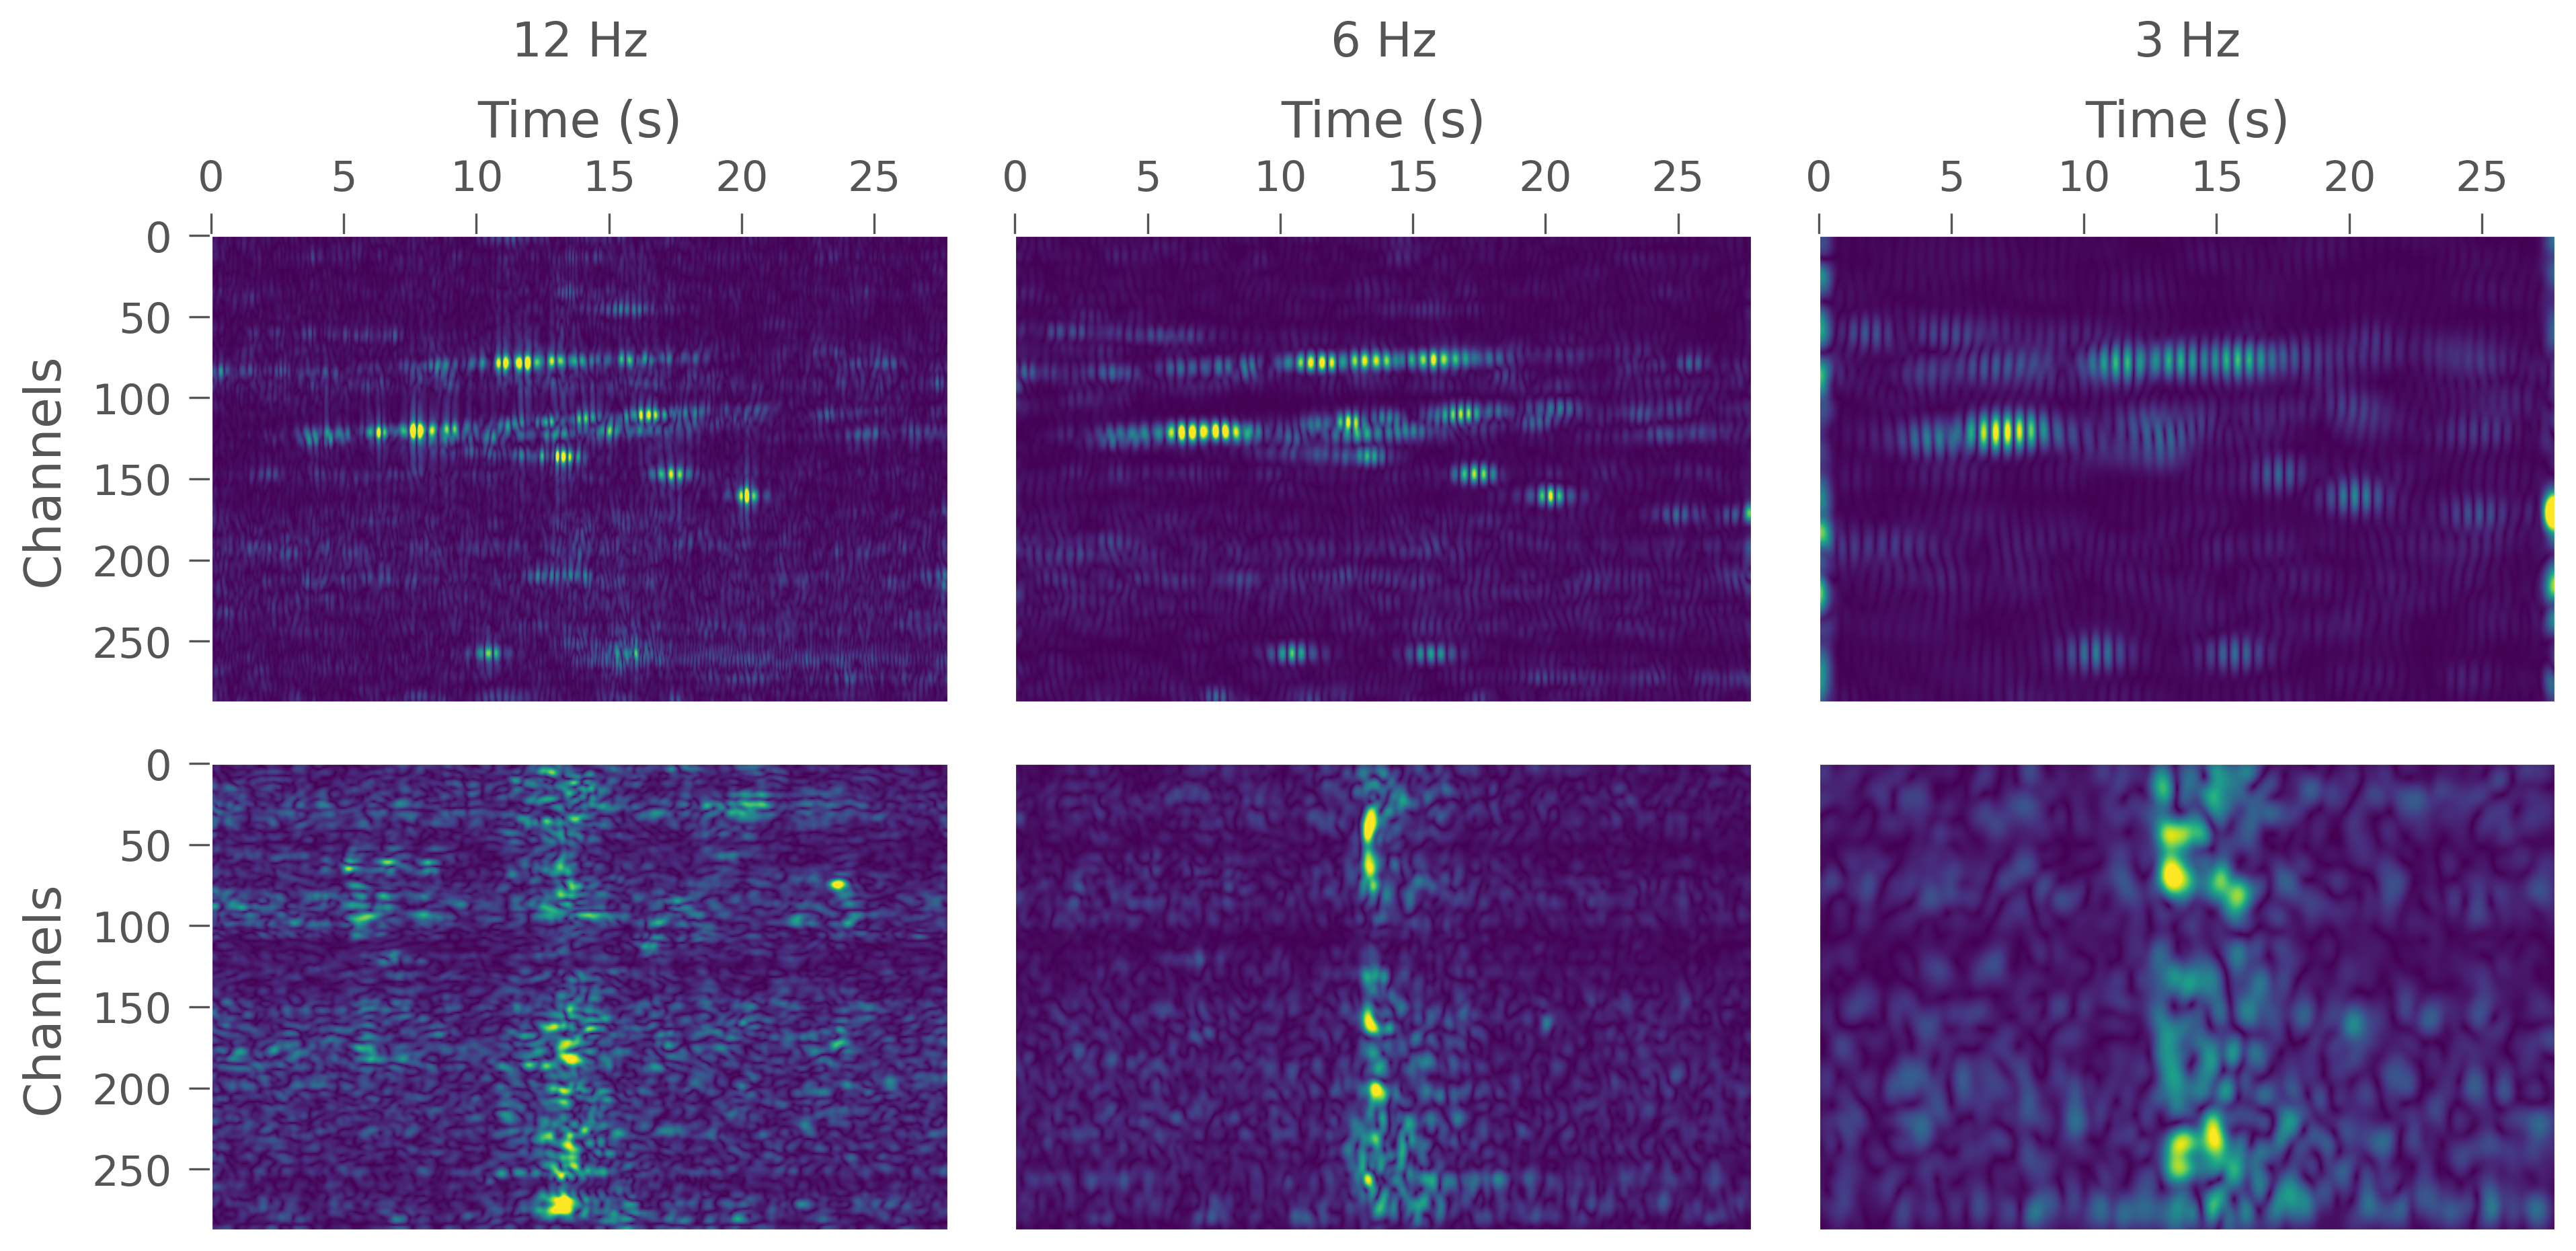

In [130]:
with plt.style.context('plot_utils/custom.mplstyle'):
    plt.rcParams['font.size'] = 15
    Xtmp = np.delete(X, [1, 2, 4, 5, 6], axis=1)
    thetas_tmp = np.delete(thetas, [1, 2, 4, 5, 6])
    cwt2d(Xtmp[:3,:,:,:], dt, dx, scales[:3], thetas_tmp, component='abs', clip=99.9, filename='event_01459_2dcwt.pdf')

In [103]:
X.shape

(9, 7, 695, 288)

In [77]:
1/1.93602662

0.5165218234447624

In [ ]:
            if j == 0: 
                ax.axis('off')
                if i > 0: 
                    width = (1 + 0.7 * (i - 1)) / 6 * 0.8 
                    height = width * 0.4
                    ellipse = Ellipse((0.5, 0.5), width, height, 0, fc='#9b9b9b')
                    ax.add_artist(ellipse)
                    ax.set_xlim(0, 1)
                    ax.set_ylim(0, 1)
                    text = '{:2.0f}\n\n{:04.4f}'.format(f[3 + (i - 1)*2], k[3 + (i - 1)*2])
                    ax.text(0.5, 0.9, text, horizontalalignment='center', verticalalignment='center')
                    plt.arrow(0.5, 0.85, 0, 0.1, width=0.0001,head_width=0, head_length=0, fc='Black')
                else:
                    text = 'Scales       pseudo-frequency (Hz)\n\n                pseudo-wavenumber (1/m)'
                    ax.text(0.5, 0.9, text, horizontalalignment='center', verticalalignment='center')
                    plt.arrow(0.1, 0.9, 7.3, 0, width=0.005,head_width=0.1, head_length=0.07, clip_on=False, fc='Black')
            if i == 0:
                ax.axis('off')
                if j > 0:
                    text = angle_labels[j - 1]
                    ax.text(0, 0.5, text, horizontalalignment='center', verticalalignment='center', rotation='vertical')
                    plt.arrow(0.065, 0.5, 0.03, 0, width=0.0001, head_width=0, head_length=0, fc='Black')
                    plt.arrow(0.5, 0.25, 0.2 * np.cos(thetas[j-1]), 0.2 * np.sin(thetas[j-1]), width=0.005, head_width=0.05, head_length=0.05, clip_on=False, fc='#9b9b9b', ec='#9b9b9b')
                else:
                    text = 'Angles'
                    ax.text(0, 0.3, text, horizontalalignment='center', verticalalignment='center', rotation='vertical')
                    plt.arrow(0.1, 0.9, 0, -9.55, width=0.005, head_width=0.07, head_length=0.1, clip_on=False, fc='Black')